Import libraries

In [8]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set seeds for reproducibility
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
#              USER CONFIGURATION
# ==========================================

# 1. File Paths & Selection
FOLDER_PATH = "/home/zebborjesson/Documents/school/tra300_digitalization_in_sports/tra300-ski-technique-classification/data_sync/outputs"

# Filter: Only load files containing this string (e.g., "NR" or "WR")
FILE_FILTER = "NR" 

# List of specific filenames to use as the TEST set. 
# These will be excluded from training/validation automatically.
TEST_FILES = [
    "BIA24-5_NR_merged_with_gear.csv",
    "BIA24-22_NR_merged_with_gear.csv",
    "BIA24-5_WR_merged_with_gear.csv",
    "BIA24-22_WR_merged_with_gear.csv",
]

# 2. Input Features
INPUT_COLS = [
    'speed_kmph', 'power_w', 'frequency_ppm', 
    'thrust_left_ms', 'thrust_right_ms', 
    'impulse_left_ns', 'impulse_right_ns', 
    'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 
    'ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts'
]

# 3. Output Label
LABEL_COL = "Gear"

# 4. Data Processing
SEQ_LEN = 5       # Frames
STEP = 1           # Stride
TRANSITION_WINDOW = 3 # +/- frames around a gear change to consider unstable

# 5. Model Architecture
HIDDEN_DIM = 32
NUM_LAYERS = 3
DROPOUT = 0.2

# 6. Training Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.00005
EPOCHS = 120

Using device: cpu


In [9]:
# --- HELPER FUNCTIONS ---
def normalize_label(val: object) -> str:
    s = str(val).strip()
    m = re.search(r'^-?\d+(?:\.\d+)?', s)
    if m:
        return f"{float(m.group(0)):.1f}"
    return s

def add_ratios(df):
    df = df.copy()
    eps = 1e-6
    if 'force_meanl_n' in df.columns and 'force_meanr_n' in df.columns:
        df["force_ratio"] = df["force_meanl_n"] / (df["force_meanl_n"] + df["force_meanr_n"] + eps)
    if 'thrust_left_ms' in df.columns and 'thrust_right_ms' in df.columns:
        df["thrust_ratio"] = df["thrust_left_ms"] / (df["thrust_left_ms"] + df["thrust_right_ms"] + eps)
    if 'impulse_left_ns' in df.columns and 'impulse_right_ns' in df.columns:
        df["impulse_ratio"] = df["impulse_left_ns"] / (df["impulse_left_ns"] + df["impulse_right_ns"] + eps)
    return df

def filter_unstable_gears(df, label_col, window_size):
    if df.empty: return df
    gear_changes = df[label_col].ne(df[label_col].shift(1))
    change_points = df[gear_changes].index.tolist()
    remove_indices = set()
    for idx in change_points:
        for i in range(idx - window_size, idx + window_size):
            remove_indices.add(i)
    return df.drop(index=list(remove_indices), errors='ignore')

def make_sure_numeric(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# --- LOAD DATA ---
all_csvs = [f for f in os.listdir(FOLDER_PATH) if f.endswith('.csv')]
csv_files = [f for f in all_csvs if FILE_FILTER in f] if FILE_FILTER else all_csvs
print(f"Found {len(csv_files)} files matching filter '{FILE_FILTER}'.")

dataframes = {}
for file in csv_files:
    full_path = os.path.join(FOLDER_PATH, file)
    df = pd.read_csv(full_path)
    
    # Process
    df = make_sure_numeric(df, INPUT_COLS)
    df = add_ratios(df)
    
    # SAFETY CHECK: If a file has completely empty numeric columns, drop it to avoid errors later
    if df[INPUT_COLS].isna().all().any():
        print(f"WARNING: File {file} has completely empty feature columns. It will be dropped.")
        continue

    if LABEL_COL in df.columns:
        df[LABEL_COL] = df[LABEL_COL].apply(normalize_label)
        if TRANSITION_SAMPLES_TO_REMOVE > 0:
            df = filter_unstable_gears(df, LABEL_COL, TRANSITION_SAMPLES_TO_REMOVE)
    
    dataframes[file] = df

# Verify Test Files exist
valid_test_files = [tf for tf in TEST_FILES if tf in dataframes]
if len(valid_test_files) != len(TEST_FILES):
    print(f"WARNING: Some test files were not found. Using: {valid_test_files}")
TEST_FILES = valid_test_files

Found 12 files matching filter 'NR'.


In [10]:
# 1. Identify keys available for training (All files MINUS test files)
train_pool_keys = sorted([k for k in dataframes.keys() if k not in TEST_FILES])

# CRITICAL SAFETY CHECK: Ensure no overlap
assert len(set(train_pool_keys).intersection(set(TEST_FILES))) == 0, "CRITICAL ERROR: Test files are leaking into the Training set!"

# 2. Split files for Train/Val
train_keys, val_keys = train_test_split(train_pool_keys, test_size=0.2, random_state=42)

print(f"Train files: {len(train_keys)} | Val files: {len(val_keys)} | Test files: {len(TEST_FILES)}")

# 3. Concatenate
train_df = pd.concat([dataframes[k] for k in train_keys], ignore_index=True)
val_df = pd.concat([dataframes[k] for k in val_keys], ignore_index=True)

test_dfs_list = [dataframes[k] for k in TEST_FILES]
if test_dfs_list:
    test_df = pd.concat(test_dfs_list, ignore_index=True)
else:
    raise ValueError("No valid test files found! Check your configuration.")

# Drop NaNs
print(f"Original Train size: {len(train_df)}")
train_df = train_df.dropna(subset=INPUT_COLS + [LABEL_COL])
val_df = val_df.dropna(subset=INPUT_COLS + [LABEL_COL])
test_df = test_df.dropna(subset=INPUT_COLS + [LABEL_COL])
print(f"Cleaned Train size:  {len(train_df)}")

# 4. Fit Label Encoder
# We sort the labels to ensure Class 0 is always the "lowest" gear (alphanumerically)
all_labels = sorted(pd.concat([train_df[LABEL_COL], val_df[LABEL_COL], test_df[LABEL_COL]]).unique())

encoder = LabelEncoder()
encoder.fit(all_labels)
print(f"Classes found (sorted): {encoder.classes_}")

# 5. Fit Scaler (TRAIN ONLY)
scaler = StandardScaler()
scaler.fit(train_df[INPUT_COLS])
print("Scaler fitted on training data.")

Train files: 8 | Val files: 2 | Test files: 2
Original Train size: 7055
Cleaned Train size:  7055
Classes found (sorted): ['0.0' '2.0' '3.0' '4.0']
Scaler fitted on training data.


In [11]:
def prepare_dataset(df):
    X_vals = df[INPUT_COLS].values
    y_vals = encoder.transform(df[LABEL_COL].values)
    
    # Scale features
    X_vals = scaler.transform(X_vals)
    
    # Convert to Tensors
    X_t = torch.tensor(X_vals, dtype=torch.float32)
    y_t = torch.tensor(y_vals, dtype=torch.long)
    
    return X_t, y_t

print("Building tensors...")
X_train, y_train = prepare_dataset(train_df)
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

Building tensors...
Train shape: torch.Size([7055, 14])
Val shape:   torch.Size([1828, 14])
Test shape:  torch.Size([1921, 14])


/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/zebborjesson/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [12]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, dropout=0.2):
        super(MLP, self).__init__()
        
        # 3 Hidden Layers (as per your previous config)
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)

# Compute class weights for imbalance
class_counts = torch.bincount(y_train)
class_weights = 1.0 / class_counts.float().clamp_min(1.0)
class_weights = class_weights * (len(class_counts) / class_weights.sum())
class_weights = class_weights.to(device)

print("Class Weights:", class_weights)

# Initialize Model
model = MLP(
    in_dim=len(INPUT_COLS),
    out_dim=len(encoder.classes_),
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Class Weights: tensor([1.0170, 1.1391, 0.3448, 1.4991])


Starting training...
Epoch [10/120] Train Loss: 0.9837 | Val Loss: 1.1296 | Val Acc: 51.86%
Epoch [20/120] Train Loss: 0.7071 | Val Loss: 0.8487 | Val Acc: 70.24%
Epoch [30/120] Train Loss: 0.6211 | Val Loss: 0.8527 | Val Acc: 72.76%
Epoch [40/120] Train Loss: 0.5791 | Val Loss: 0.8449 | Val Acc: 73.41%
Epoch [50/120] Train Loss: 0.5502 | Val Loss: 0.8381 | Val Acc: 73.47%
Epoch [60/120] Train Loss: 0.5496 | Val Loss: 0.8252 | Val Acc: 73.85%
Epoch [70/120] Train Loss: 0.5184 | Val Loss: 0.8321 | Val Acc: 74.02%
Epoch [80/120] Train Loss: 0.5110 | Val Loss: 0.8341 | Val Acc: 73.96%
Epoch [90/120] Train Loss: 0.5019 | Val Loss: 0.8387 | Val Acc: 73.96%
Epoch [100/120] Train Loss: 0.4855 | Val Loss: 0.8406 | Val Acc: 74.23%
Epoch [110/120] Train Loss: 0.4822 | Val Loss: 0.8410 | Val Acc: 74.23%
Epoch [120/120] Train Loss: 0.4631 | Val Loss: 0.8526 | Val Acc: 74.40%

Restoring best model (Val Loss: 0.8239)


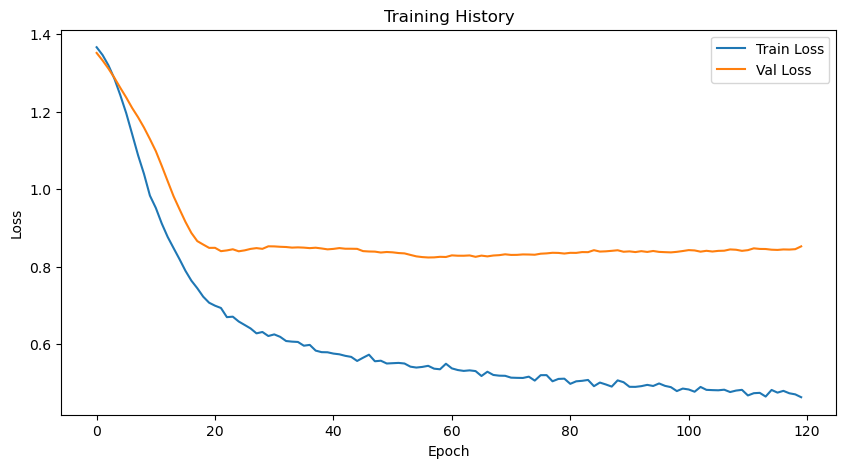

In [13]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct / total

    # Save Best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Load Best Model
if best_model_state:
    print(f"\nRestoring best model (Val Loss: {best_val_loss:.4f})")
    model.load_state_dict(best_model_state)

# Plot
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


--- Test Set Classification Report ---
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       272
         2.0       0.93      0.97      0.95       303
         3.0       0.97      0.86      0.91      1265
         4.0       0.26      0.59      0.36        81

    accuracy                           0.88      1921
   macro avg       0.76      0.84      0.78      1921
weighted avg       0.92      0.88      0.89      1921



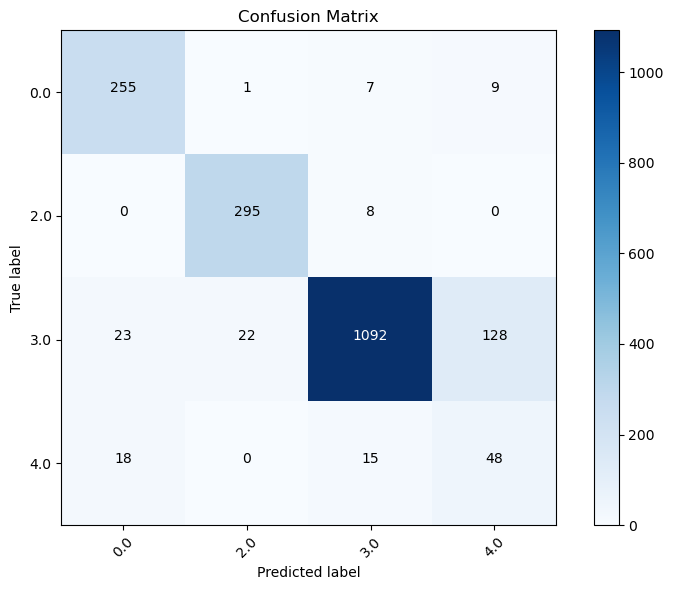

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

# Evaluation Metrics
print("\n--- Test Set Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=encoder.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(encoder.classes_))
plt.xticks(tick_marks, encoder.classes_, rotation=45)
plt.yticks(tick_marks, encoder.classes_)

# Label the squares
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

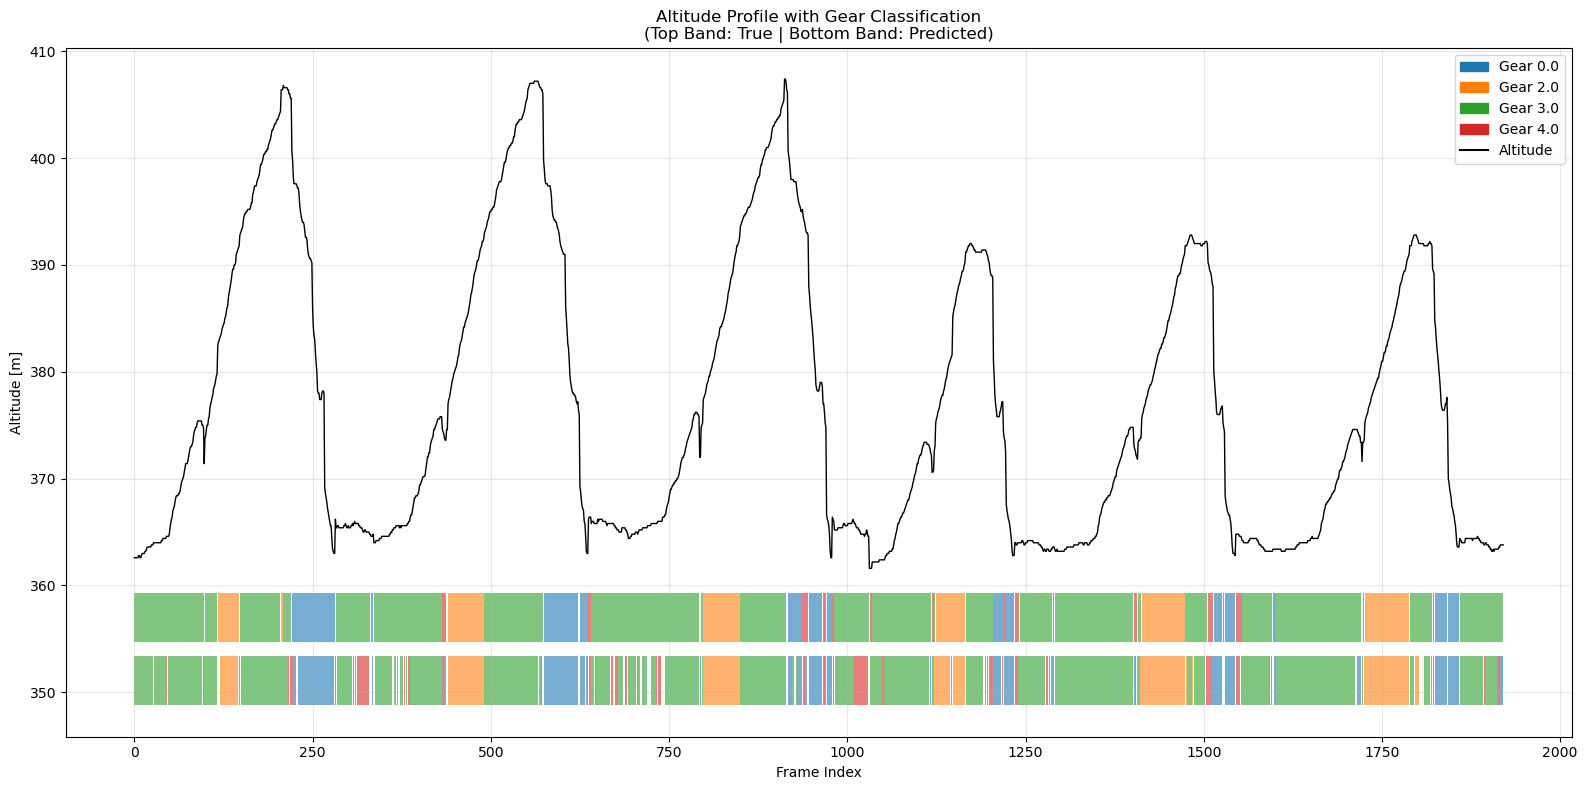

In [15]:
# ==========================================
# ALTITUDE vs TIME + TRUE/PRED GEAR BANDS
# ==========================================
import matplotlib.patches as mpatches

# 1. Align Data
# Since MLP is frame-by-frame (no sequence offset), indices match exactly.
# We just need to handle the case where 'Time' might be missing.

time_col = 'Time' if 'Time' in test_df.columns else None
if time_col:
    t = test_df[time_col].values
else:
    print("Warning: 'Time' column not found. Using DataFrame index.")
    t = test_df.index.values

# Altitude
alt = test_df['ns1:AltitudeMeters'].values

# Predictions and True Labels
pred_int = np.array(all_preds)
true_int = np.array(all_labels)

# Ensure all arrays are the exact same length (just a safety check)
min_len = min(len(t), len(alt), len(pred_int), len(true_int))
t = t[:min_len]
alt = alt[:min_len]
pred_int = pred_int[:min_len]
true_int = true_int[:min_len]

# 2. Decode Labels (Integers -> Original Strings)
pred_str = encoder.inverse_transform(pred_int)
true_str = encoder.inverse_transform(true_int)
unique_classes_str = encoder.classes_

# 3. Setup Colors
# Assign a unique color to each class for consistency
cmap = plt.get_cmap("tab10")
class_to_color = {cls_name: cmap(i) for i, cls_name in enumerate(unique_classes_str)}

# 4. Plotting
plt.figure(figsize=(16, 8))

# A. Plot Altitude
plt.plot(t, alt, color='black', linewidth=1, label="Altitude", zorder=10)

# Calculate dynamic y-positions for the bands based on altitude range
y_min, y_max = alt.min(), alt.max()
y_range = y_max - y_min
if y_range == 0: y_range = 10  # Prevent division by zero if flat

# Band positions (placed slightly below the minimum altitude)
true_band_top = y_min - (0.05 * y_range)
true_band_bot = y_min - (0.15 * y_range)
pred_band_top = y_min - (0.18 * y_range)
pred_band_bot = y_min - (0.28 * y_range)

# B. Plot TRUE Gear Band
for cls_name in unique_classes_str:
    mask = (true_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, true_band_bot, true_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid',  # 'mid' ensures sharp transitions for discrete data
            linewidth=0
        )

# C. Plot PREDICTED Gear Band
for cls_name in unique_classes_str:
    mask = (pred_str == cls_name)
    if np.any(mask):
        plt.fill_between(
            t, pred_band_bot, pred_band_top,
            where=mask,
            color=class_to_color[cls_name],
            alpha=0.6,
            step='mid',
            linewidth=0
        )

# D. Formatting & Legend
plt.xlabel("Time" if time_col else "Frame Index")
plt.ylabel("Altitude [m]")
plt.title("Altitude Profile with Gear Classification\n(Top Band: True | Bottom Band: Predicted)")

# Create custom legend handles
handles = [mpatches.Patch(color=class_to_color[c], label=f"Gear {c}") for c in unique_classes_str]
handles.append(plt.Line2D([], [], color='black', label='Altitude'))

plt.legend(handles=handles, loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()